## ЦЕЛЬ
#### Подготовить основу рекомендательной системы.

### ЗАДАНИЕ
#### Вам необходимо оформить таблицу, которая станет основой рекомендательной системы.

#### Итоговая таблица должна состоять из трёх столбцов:

- Курс, к которому идёт рекомендация.
- Курс для рекомендации № 1 (самый популярный).
- Курс для рекомендации № 2 (второй по популярности).

#### подключаемся к БД

In [28]:
import psycopg2
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

try:
    connection = psycopg2.connect(
        dbname='skillfactory',                          
        user='skillfactory',                           
        host='84.201.134.129',                           
        password='cCkxxLVrDE8EbvjueeMedPKt',
        port=5432
    )
    cursor = connection.cursor()
    # готовим файл с данными по продажам курсов в разрезе пользователей (купивших более одного курса)
    cursor.execute(
    """with info_t as(
    SELECT user_id
    FROM final.carts c
    JOIN final.cart_items ci ON c.id=ci.cart_id
    WHERE state='successful' AND resource_type='Course'
    GROUP BY 1
    HAVING count(distinct resource_id) >1)
    
    SELECT distinct user_id, Resource_ID
    FROM final.carts c
    JOIN final.cart_items ci ON c.id=ci.cart_id
    WHERE state='successful' AND resource_type='Course' AND user_id in (select user_id from info_t)
    ORDER BY 1 desc,2;""")
    record = cursor.fetchall()
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL connection is closed


#### делаю таблицу с данными по продажам курсов в разрезе пользователей (купивших более одного курса).

In [29]:
# делаю датафрейм и оставлю список record
record_df = pd.DataFrame(record)
record_df.columns = ['user_id', 'course_id']
record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    34074 non-null  int64
 1   course_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


In [30]:
record = Counter(record_df['course_id']).most_common() # наиболее популярные курсы
record[:10] # использую это ниже в расчётах

[(551, 2935),
 (566, 2342),
 (515, 1311),
 (489, 1125),
 (490, 1084),
 (523, 1053),
 (514, 983),
 (794, 875),
 (745, 829),
 (570, 720)]

In [31]:
record_df = record_df.groupby('user_id', as_index = False)['course_id'].agg(list) # группирую в список курсы пользователей
record_df

,user_id,course_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


In [32]:
import itertools # импортирую для удобства библиотеку
from pprint import pprint

# переберу по парам все курсы
list_courses = list()
for course in record_df['course_id']:
    for x in itertools.combinations(course, 2):  
        list_courses.append(x)
        
x_counter = Counter(list_courses) # здесь счётчик групп
x_counter = x_counter.most_common()
print(len(x_counter)) # число пар курсов
pprint(x_counter[:10])

3989
[((551, 566), 797),
 ((515, 551), 417),
 ((489, 551), 311),
 ((523, 551), 304),
 ((566, 794), 290),
 ((489, 515), 286),
 ((490, 566), 253),
 ((490, 551), 247),
 ((570, 752), 247),
 ((569, 572), 216)]


In [33]:
x_counter_df = pd.DataFrame(x_counter)
x_counter_df = x_counter_df # таблица популярных пар курсов
x_counter_df 

,0,1
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
...,...,...
3984,"(741, 791)",1
3985,"(361, 1128)",1
3986,"(743, 1156)",1
3987,"(864, 1129)",1


In [34]:
try:
    connection = psycopg2.connect(
        dbname='skillfactory',                          
        user='skillfactory',                           
        host='84.201.134.129',                           
        password='cCkxxLVrDE8EbvjueeMedPKt',
        port=5432
    )
    cursor = connection.cursor()
    # файл с данными по продажам курсов в разрезе пользователей (купивших более одного курса)
    cursor.execute(
    """SELECT count(distinct user_id)
    FROM final.carts c
    JOIN final.cart_items ci ON c.id=ci.cart_id
    WHERE resource_type='Course'
	;""")
    all_users = cursor.fetchall()
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")
        
print(all_users)

PostgreSQL connection is closed
[(68989,)]


Чтобы сделать задание, надо бы исследовать аудиторию, которая покупает курсы, но таких данных у нас нет. Но что-то сделать можно.
При исследовании данных я выяснил, что курсы рассматривали 68989 человек, покупали 49_006(71% от всех пользователей) человек, более одного курса купили - 12_656(25.8% от купивших курс или 18.34% от всех пользователей) человек и в среднем покупают 1.44 курса на человека, а также всего 127 видов курсов.

In [35]:
# присмотримся к данным
record_df['lenth'] = record_df.course_id.apply(len)
users_max = record_df[record_df['lenth'] > 2].user_id.nunique()
users_max_df = record_df[record_df['lenth'] > 2]
users_max_df

,user_id,course_id,lenth
1,6117,"[356, 357, 1125]",3
10,24640,"[514, 517, 566]",3
11,26191,"[363, 511, 562, 563]",4
13,30789,"[509, 553, 745]",3
15,31237,"[509, 568, 672]",3
...,...,...,...
12636,2147935,"[361, 813, 1100, 1124, 1128]",5
12648,2172942,"[504, 569, 840]",3
12652,2186581,"[794, 864, 1129]",3
12653,2187601,"[356, 553, 571, 765, 912]",5


In [36]:
# 12_656 - 4602 = 8054 (64% - столько пользователей покупает пару курсов) и 4602(36% более 2)

In [37]:
# не забудем про популярные курсы
dict_record = dict(record) # делал переменную ранее
len(dict_record)

126

курсов 127, а в наших данных лишь 126, так как у нас срез по клиентам, которые покупали более 1 курса, возможно один курс не попал в нашу группу. Я нашёл айди такого курса 772, проверим есть ли он в словаре выше.

In [38]:
772 in dict_record # результат False - значит курс отстуствует. Я проверил, всего два пользователя его создали, но не купили, 
# возможно курс новый, продолжим. На тот курс не будем обращать внимание, не имеет значимости.

False

In [39]:
# попробуем найти пересечения этих курсов(более 2-х)
x = Counter()
for i in users_max_df.course_id:
    x += Counter(i)
    
x = x.most_common() # популярные курсы при покупках более 2-х, возможно пригодится

recommend_df = pd.DataFrame(x) #будущий датафрейм со списком курсов - 126

recommend_df = recommend_df.drop(columns = 1)
recommend_df.columns = ['main']
# recommend_df = recommend_df.astype('string')
recommend_df = recommend_df.drop_duplicates() # станет основой для списка курсов
recommend_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   main    126 non-null    int64
dtypes: int64(1)
memory usage: 2.0 KB


In [40]:
# таблица популярных пар курсов, которую я делал раньше
x_counter_df  = x_counter_df.copy() # чтобы не ругался на ошибки
x_counter_df[0]  = x_counter_df[0].apply(list) 
x_counter_df[0] = x_counter_df[0].apply(lambda x: list(map(str,x))) # надо поделить список по столбцам
x_counter_df[2] = x_counter_df[0].apply(lambda x: x[0])
x_counter_df[3] = x_counter_df[0].apply(lambda x: x[1])
x_counter_df = x_counter_df[[1,2,3]] 
x_counter_df.columns = ['rait', 'course1', 'course2'] # таблица откуда будем вытаскивать рекомендации для курсов
x_counter_df.iloc[:,1:4] = x_counter_df.iloc[:,1:4].astype('int64')
x_counter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   rait     3989 non-null   int64
 1   course1  3989 non-null   int64
 2   course2  3989 non-null   int64
dtypes: int64(3)
memory usage: 93.6 KB


C:\Users\ALFA\AppData\Local\Temp\ipykernel_13620\494835344.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_counter_df.iloc[:,1:4] = x_counter_df.iloc[:,1:4].astype('int64')


### объединяем таблички

In [41]:
total_df = recommend_df.merge(x_counter_df, left_on='main', right_on = 'course1', how ='left')
total_df = total_df[['main', 'course2', 'rait']]
total_df.rename({'course2': 'recommend_1'}, axis = 1, inplace = True)
total_df = total_df.drop_duplicates(subset = 'main').reset_index(drop = True) #проверка на дубли основных курсов
total_df # их 126 - всё верно

,main,recommend_1,rait
0,551,566.0,797.0
1,566,794.0,290.0
2,515,551.0,417.0
3,523,551.0,304.0
4,489,551.0,311.0
...,...,...,...
121,833,NaN,NaN
122,1199,NaN,NaN
123,1201,NaN,NaN
124,902,NaN,NaN


In [42]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   main         126 non-null    int64  
 1   recommend_1  117 non-null    float64
 2   rait         117 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


In [43]:
x_counter_df1 = x_counter_df.copy()
x_counter_df1['course1'] = x_counter_df.loc[:, ['course1']].astype('int64')
x_counter_df1 = x_counter_df1.sort_values(by = ['course1', 'rait'], ascending = [True, False])
x_counter_df1 = x_counter_df1[x_counter_df1.duplicated(subset= 'course1')] # оставляем все дубликаты кроме первых
x_counter_df1 = x_counter_df1.drop_duplicates(subset = 'course1') # оставляем только первые дубликаты, которые теперь будут вторыми по популярности
x_counter_df1

,rait,course1,course2
50,100,356,357
137,52,357,1125
467,19,358,752
769,12,359,507
744,12,360,516
...,...,...,...
1400,5,1146,1187
3829,1,1156,1181
3901,1,1161,1182
2313,2,1185,1187


### объединяем таблички

In [44]:
total_df['main'] = total_df['main'].astype('int64')
merge_df = total_df.merge(x_counter_df1, left_on='main', right_on='course1', how = 'left')
merge_df = merge_df.drop_duplicates(subset = 'main')
merge_df = merge_df.drop_duplicates() # проверка на дубли
merge_df = merge_df[['main', 'recommend_1', 'course2']] # сохраняем нужные строки
merge_df = merge_df.rename({'course2': 'recommend_2'}, axis = 1)
merge_df # таблица частично готова

,main,recommend_1,recommend_2
0,551,566.0,552.0
1,566,794.0,764.0
2,515,551.0,523.0
3,523,551.0,552.0
4,489,551.0,515.0
...,...,...,...
121,833,NaN,NaN
122,1199,NaN,NaN
123,1201,NaN,NaN
124,902,NaN,NaN


In [45]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   main         126 non-null    int64  
 1   recommend_1  117 non-null    float64
 2   recommend_2  112 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.9 KB


#### что делать с пропусками? вернёмся к x_counter_df, где комбинации пар курсов, возможно, что некоторые курсы не начинают пары.

In [46]:
merge_df[['recommend_1','recommend_2']] = merge_df[['recommend_1','recommend_2']].fillna(0) # посмотрим на пустые значения и отфильруем их
main_list = merge_df['main'][merge_df['recommend_1'] == 0].to_list() # сохраним такие курсы в список
main_list2 = merge_df['main'][merge_df['recommend_2'] == 0].to_list() # сохраним такие курсы в список

In [47]:
main_list # смотрим на такие пропуски


[1184, 1188, 1160, 1198, 833, 1199, 1201, 902, 1200]

In [48]:
main_list2

[1152,
 1184,
 1187,
 1181,
 1147,
 1188,
 1160,
 1198,
 1182,
 833,
 1199,
 1201,
 902,
 1200]

####  смотрим пары курсов, которые заканчивались на курсы из списка

In [49]:
concat_df1 = pd.DataFrame() # напишу крутой скрипт, чтобы код был короче и покажу свой класс )))))
for i in (main_list2 + main_list):
    concat_df1 = pd.concat([concat_df1,x_counter_df[x_counter_df['course2'] == i].head(2)]).reset_index(drop=True)
    
concat_df1.sort_values('rait', ascending=False).head(10)

,rait,course1,course2
4,32,745,1187
28,27,752,1184
2,27,752,1184
5,27,553,1187
8,26,745,1147
29,26,507,1184
0,26,551,1152
3,26,507,1184
1,25,490,1152
6,20,752,1181


#### Значения рейтинга не сильно велики, буду советовать два по популярности курса в качестве 1 и 2 рекомендаций (745,752)

In [50]:
total_recommend_df = merge_df
total_recommend_df['recommend_1'] = total_recommend_df['recommend_1'].apply(lambda x: 745 if x==0 else x)
total_recommend_df['recommend_2'] = total_recommend_df['recommend_2'].apply(lambda x: 752 if x==0 else x)
total_recommend_df = total_recommend_df.sort_values(by = 'main')

In [51]:
total_recommend_df['recommend_1'] = total_recommend_df['recommend_1'].astype('int64')
total_recommend_df['recommend_2'] = total_recommend_df['recommend_2'].astype('int64') # почему-то тип заменился на флоат, сделаем красиво
total_recommend_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 32 to 123
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   main         126 non-null    int64
 1   recommend_1  126 non-null    int64
 2   recommend_2  126 non-null    int64
dtypes: int64(3)
memory usage: 3.9 KB


In [52]:
total_recommend_df

,main,recommend_1,recommend_2
32,356,571,357
31,357,571,1125
90,358,570,752
97,359,570,507
102,360,745,516
...,...,...,...
104,1188,745,752
115,1198,745,752
122,1199,745,752
125,1200,745,752


#### Таблица с рекомендациями готова

In [53]:
x_counter_df

,rait,course1,course2
0,797,551,566
1,417,515,551
2,311,489,551
3,304,523,551
4,290,566,794
...,...,...,...
3984,1,741,791
3985,1,361,1128
3986,1,743,1156
3987,1,864,1129


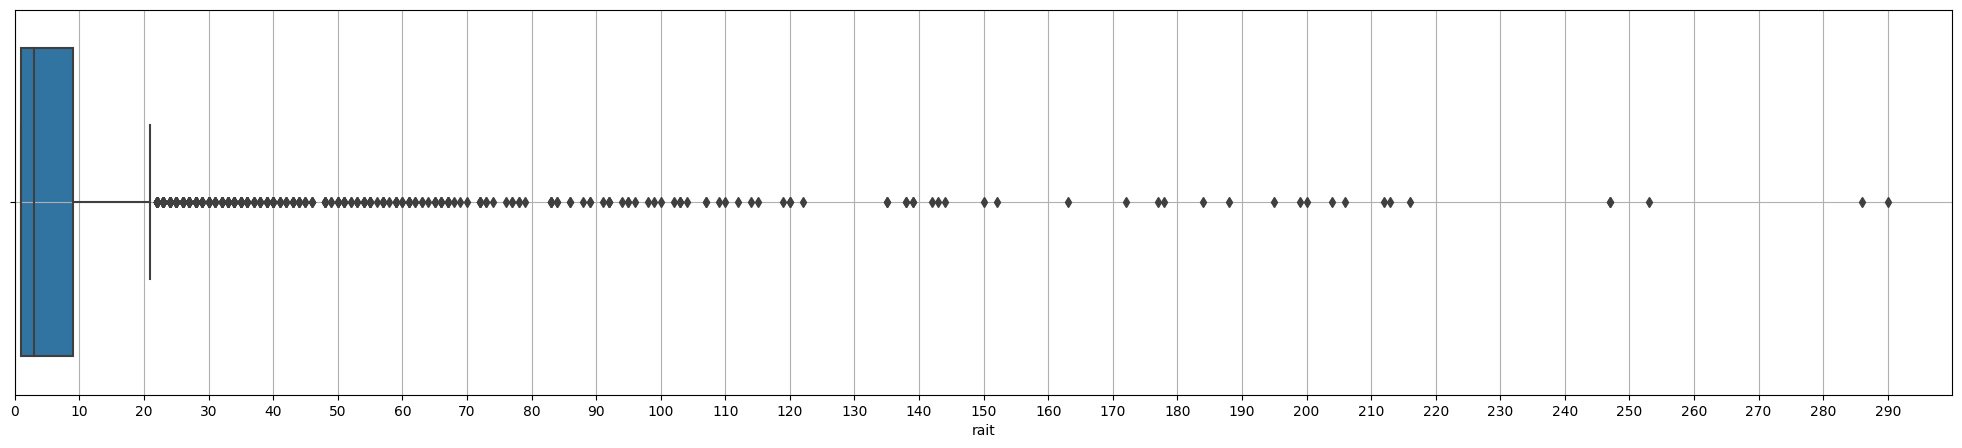

In [54]:
plt.figure(figsize=(25,5))
sns.boxplot(data=x_counter_df, x='rait')
plt.xlim([0,300])
plt.xticks(range(0,300,10))
plt.grid()

## Комментарий о выборе минимальной границы для частотности рекомендаций 
#### я выбрал для первой рекомендации самую популярную пару курсов, а для второй - вторую. На графике видно, что большинство значений рейтинга пар курсов от 0 до 21 (примерно), считаю эти значения маленькими для рекомендаций и рекомендую использовать в качестве минимальной границы число 21